In [1]:
import cv2
import os
import glob

In [4]:
#unifying covid images to 512 by 512 pixels
try:
    os.mkdir('covid_dataset/covid_resized')
except OSError:
    pass

img_dir = "covid_dataset/covid/"
data_path = os.path.join(img_dir,'*.png')
files = glob.glob(data_path)
w = 512
h = 512
i = 1
for f1 in files:
    img = cv2.imread(f1)
    resized = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
    cv2.imwrite('covid_dataset/covid_resized/positive'+str(i)+'.png',resized)
    i +=1


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
import os
try:
    os.mkdir('covid_dataset/training')
    os.mkdir('covid_dataset/testing')
    os.mkdir('covid_dataset/training/positive')
    os.mkdir('covid_dataset/training/negative')
    os.mkdir('covid_dataset/testing/positive')
    os.mkdir('covid_dataset/testing/negative')
except OSError:
    pass

In [4]:
#splitting data into training and testing
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [5]:
positive_DIR = 'covid_dataset/covid_resized/'
negative_DIR = 'covid_dataset/noncovid/'
positive_training = 'covid_dataset/training/positive/' 
negative_training = 'covid_dataset/training/negative/'
positive_testing = 'covid_dataset/testing/positive/'
negative_testing = 'covid_dataset/testing/negative/'
split_size = .8

In [6]:
split_data(positive_DIR, positive_training, positive_testing, split_size)
split_data(negative_DIR, negative_training, negative_testing, split_size)

In [7]:
print(len(os.listdir('covid_dataset/training/negative/')))
print(len(os.listdir('covid_dataset/testing/negative/')))

800
200


In [8]:
#building the model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(512,512,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
training_DIR = 'covid_dataset/training/'
testing_DIR = 'covid_dataset/testing/'

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(training_DIR,
                                                    target_size=(512,512),
                                                    batch_size=32,

                                                    class_mode='categorical')


testing_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')
testing_generator = testing_datagen.flow_from_directory(testing_DIR,
                                                              target_size=(512,512),
                                                              batch_size=32,
                                                                
                                                              class_mode='categorical')

Found 1011 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [10]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=testing_generator)

Epoch 1/10
32/32 [==============================] - 277s 9s/step - loss: 0.8187 - accuracy: 0.7676 - val_loss: 0.3340 - val_accuracy: 0.9328
Epoch 2/10
32/32 [==============================] - 280s 9s/step - loss: 0.1680 - accuracy: 0.9565 - val_loss: 0.2703 - val_accuracy: 0.9407
Epoch 3/10
32/32 [==============================] - 242s 8s/step - loss: 0.0984 - accuracy: 0.9723 - val_loss: 0.3036 - val_accuracy: 0.9249
Epoch 4/10
32/32 [==============================] - 245s 8s/step - loss: 0.0914 - accuracy: 0.9753 - val_loss: 0.2109 - val_accuracy: 0.9012
Epoch 5/10
32/32 [==============================] - 241s 8s/step - loss: 0.0577 - accuracy: 0.9852 - val_loss: 0.1648 - val_accuracy: 0.9328
Epoch 6/10
32/32 [==============================] - 236s 7s/step - loss: 0.0317 - accuracy: 0.9921 - val_loss: 0.0215 - val_accuracy: 0.9881
Epoch 7/10
32/32 [==============================] - 247s 8s/step - loss: 0.0656 - accuracy: 0.9832 - val_loss: 0.1497 - val_accuracy: 0.9051
Epoch 8/10
32

<Figure size 432x288 with 0 Axes>

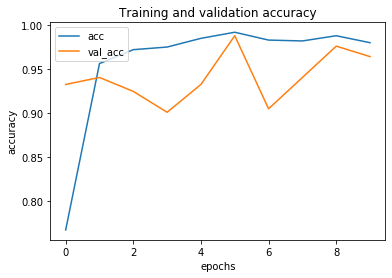

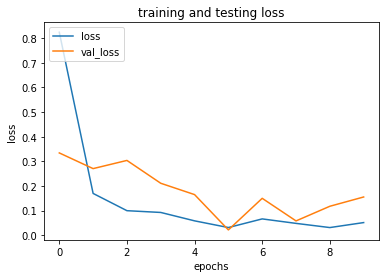

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs=range(len('acc')) # number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and validation accuracy')
plt.legend(loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------

plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('training and testing loss')
plt.legend(loc='upper left')
plt.figure()